# HW4: Self-Attention and the Vision Transformer (ViT)
In this homework we will be looking at self-attention and the transformer. Since the release of "Attention is All you Need" in 2017, attention and transformers have quickly grown in popularity. Originally introduced as a seq2seq model for natural language processing, transformers have seen adoption in other ML areas such as vision. First introduced in "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", the Vision Transformer (ViT) has achieved SOTA results in many vision tasks.

This notebook was put together by Keaton Kraiger

## Model Overview
When ViT was introduced, self-attention and transformers were already well established. A major contribution in the ViT was
- splitting an image into fixed-size patches
- linearly embedding each patch
- add a positional embedding
- give resulting sequence to a standard transformer.


To perform classification, ViT adds an extra learnable "classification token" to the sequence.
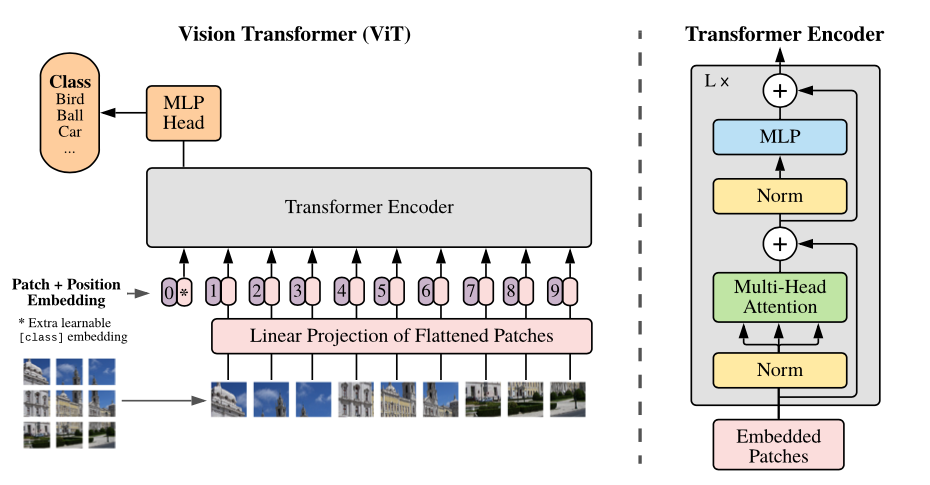

Let's install some packages. Note that einops is a useful package for tensor operations.

In [ ]:
# Lets install some packages
%pip install einops
from einops import rearrange, repeat
from einops.layers.torch import Rearrange

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.optim.lr_scheduler import StepLR
from torch import optim

import torchvision
import torchvision.transforms as transforms

import random
import os

In our code, we will be mostly following the ViT figure shown previously. Luckily for us, ViT is a fairly simple model.

We will be constructing the ViT with a few different classes, then placing everything together. All classes are `nn.Module`. Below we create a class for applying LayerNorm for our Transformer.

In [ ]:
# helper
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# apply layer norm
class PreNorm(nn.Module):
  def __init__(self, dim, fn):
    super().__init__()
    self.norm = nn.LayerNorm(dim)
    self.fn = fn
  def forward(self,x, **kwargs):
    return self.fn(self.norm(x), **kwargs)

We can see in the figure, Transformers include a MLP for obtaining a linear transformation following the attention operation.

Below we define `MLP`. Let's follow the implementation in the ViT paper. Using PyTorch, add network's components in order
- `Linear` layer. nn.Linear
  - in_dimension: `dim`, out_dim: `hidden_dim`
- `GELU` activation. nn.GELU
- `Dropout` layer. nn.Dropout
  - dropout probability of `dropout`
- `Linear` layer
  - What should the dimensions be?
- `Dropout` layer
  - dropout probability of `dropout`

  Below, finish completing the `MLP` class.

In [ ]:
class MLP(nn.Module):
  def __init__(self, dim, hidden_dim, dropout = 0.):
    super().__init__()
    self.net = nn.Sequential(
        # TODO 1: MLP. Define a multilayer perceptron (MLP) consisting of a Linear layer, a GELU activation function, a Dropout layer, a Linear layer, and a Dropout layer. ~ 5 lines of code.
        ### Start code
        nn.Linear(dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(hidden_dim, dim),
        nn.Dropout(dropout)
        ### End code
    )
  def forward(self,x):
    return self.net(x)

It's now time to add the attention mechanism to be used in our transformer. Here we will implement a multiheaded sefl-attention transformer.
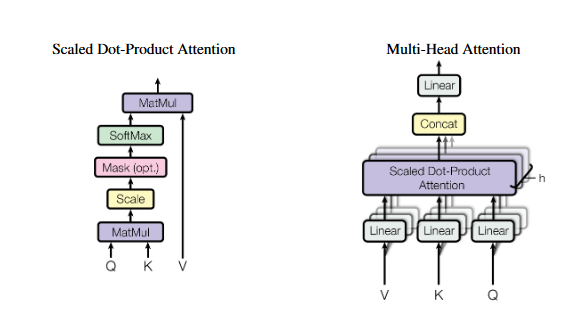

The above figure is from the original 2017 paper introducing attention. For each element in an input sequence $z$, we compute a weighted sum over all values $v$ in a sequence. The attention weights $A_{ij}$ are based on the pairwise similarity between two elements of the sequence and their respecitve query $q^i$ and key $k^j$ representations.

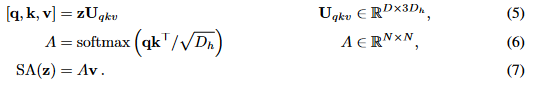

For our multiheaded attention, we have $k$ self-attention operations called "heads" in parallel and project their concatenated outputs. Below we've created `Attention` where we define the number of heads, the softmax `attend`, a linear transformation to $q, v, k$, and a final transformation `to_out`.

Let's code the actual forward implementation. We first get our $q, k, v$ values and reorder their shapes. To implement our dot-projuct attention let's follow the figure.

Recall the actual Attention operation is given by
$$
Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}}) V
$$


Given $q, k, v$, lets complete the attention calculation. Create the variables/values
- `dots`: takes the value inside softmax in the attention equation ($$\frac{QK^T}{\sqrt{d_k}}$$)
  - instead of diving by $\sqrt{d_k}$, we can multiply by the class's `scale` value.
  - hint: use torch's `matmul` function
  - hint: for our tensors operations to align, when transposing `k` you'll need to transpose along dim0 = -1 and dim1 = -2

- `attn`: applys softmax using the class's `attend` function on `dots`.
- `out`: performs matrix multiplication on `attn` and `v`
  - hint: use torch's `matmul` function.

In [ ]:
class Attention(nn.Module):
  def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
    super().__init__()
    inner_dim = dim_head * heads
    project_out = not (heads == 1 and dim_head == dim)

    self.heads = heads
    self.scale = dim_head ** -0.5

    self.attend = nn.Softmax(dim=-1)
    self.to_qkv = nn.Linear(dim, inner_dim*3, bias = False)

    self.to_out = nn.Sequential(
        nn.Linear(inner_dim, dim),
        nn.Dropout(dropout)
    ) if project_out else nn.Identity()

  def forward(self, x):
    qkv = self.to_qkv(x).chunk(3, dim=-1)
    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

    # Self-attention. Implement a self-attention mechanism

    dots = torch.matmul(q, k.transpose(-1, -2))*self.scale
    attn = self.attend(dots)
    out =  torch.matmul(attn, v)

    out = rearrange(out, 'b h n d -> b n (h d)')
    return self.to_out(out)

Next, we will create the Transformer. Looking back at the ViT figure, we see we only need an encoder. This makes sense as in the paper, the authors are performing classification, not seq2seq.

Below we create the `Transformer` class which allows us to control it's parameters. We create a `nn.ModuleList` which contains multiple `nn.Module`s. The code is fairly simple and follows the Transformer Encoder diagram where we add two Layer norms where the
- 1st performs a layer norm then gives output to the multiheaded `Attention`
- 2nd performs layer norm then gives ouptut to an `MLP`.

To achieve this we use `PreNorm` which first applies a `LayerNorm`, then applies whatever function it takes in as an arugment to the Norm. That is, for each `PreNorm` we initialize we pass in the `dim` of exepcted input and the function to apply. This is done `depth` times.

We've already created one `PreNorm`. Add the second `PreNorm` which takes
- `dim`: expected in_dim
- `MLP`: with arguments `dim`, `mlp_dim`, and `dropout`

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                # Transformer layer. Layer norm -> Self-attention -> Layer norm -> MLP

                PreNorm(dim, Attention(dim, heads, dim_head, dropout)),
                PreNorm(dim, MLP(dim, mlp_dim, dropout))

            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            # Forward function in transformers.
            #
            #apply attn and ff to x with residual connections
            x = x + attn(x)
            x = x + ff(x)

        return x

Lastly, we put it all together in `ViT`. We are only missing code to split the image into patches and obtain their embeddings. To achieve this we split, we must determine the number of patches and how many patches we will need for an image.

The paper states an we reshape an image $x \in \mathbb{R}^{HxWxC}$ into a sequence of flattended 2D patches $x_p \in \mathbb{R}^{N X (P^2 \cdot C}$ for image resolution (H,W), $C$ channels, patch resolution $(P,P)$, and $N = HW/P^2$ number of patches.

Given the image size (H,W) and parameter `patch_size` ($P_{height}, P_{width}$) create the variable
- `num_patches`: $(H // P_{height}) * (W // P_{width})$ where // is integer division.
- `patch_dim`: C * $P_{height} * P_{width}$

Next we create a `nn.Linear` to obtain patch_embeddings. Finally, we need to add positional embeddings and a class token (used to classify images). These are defined simply as learnable parameters. We've added `pos_mebedding`, now create
- `cls_token`: learnable parameters randomly initialized sized (1, 1, dim).

We will take a closer look at these patches later.

To complete the ViT, we add a transform after the Transformer and a final MLP head to classify our images.

In [ ]:
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        ### For grading purposes
        global num_patches
        global patch_dim
        ###

        #
        # 1. Compute the number of patches according to image_height, image_width, patch_height, and patch_width.
        # 2. Compute the number of dimensions of each patch according to channels, patch_height, and patch_width.

        num_patches = (image_height//patch_height) * (image_width//patch_width)
        patch_dim = channels * patch_height * patch_width


        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        # Initiailize our transformer encoder
        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        # Prepares transformer output for classifier layer.
        self.pool = pool
        self.to_latent = nn.Identity()

        # Our final classification layer.
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    # our forward function is pretty simple as well. We just pass our input
    # through all our components.
    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        # Position Embedding. Add the position embedding to inputs. 1 line of code.
        ### Start Code
        x += self.pos_embedding[:, :(n + 1)]
        ### End Code
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

## Training
We now have a network to learn with. Let's try classification on CIFAR-10.

In [ ]:
# Dont change
import random
seed = 2022
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

Below we load our dataset and create data loaders.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


We initialize our ViT. Please leave these values as they are.

In [ ]:
network = ViT(
    image_size=32,
    patch_size = 8,
    num_classes=10,
    dim = 128,
    depth=12,
    heads = 8,
    mlp_dim=128
)

Because ViT, and transformers in general are quite large, we will only be training for a few epochs. There exist "efficient" transformers,  but even these are for the part, expensive to train.

We will use CrossEntropy and Adam for optimization. For our learning rate, lets try using a scheduler, a utility very helpful for training. Create the variable
- `scheduler`: a PyTorch learning rate scheduler to decay `lr` for our `optimizer`. Use the variables defined in our cell as parameters to the scheduler.

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network.to(device)
network.train()
epochs = 3
lr = 3e-5
gamma = 0.7

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(network.parameters(), lr=lr)

# TODO 7: Exponential learning rate scheduler. see https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html.
#gamma = 0.1
### Start code
#torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1, verbose='deprecated')
lr_scheduler = ExponentialLR(optimizer, gamma)
### End code

*Let*'s train for 3 epochs, just to get an idea for training times.

In [ ]:
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = network(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

    lr_scheduler.step()

print('Finished Training')

[1,    50] loss: 0.222
[1,   100] loss: 0.211
[1,   150] loss: 0.206
[1,   200] loss: 0.200
[1,   250] loss: 0.198
[1,   300] loss: 0.193
[1,   350] loss: 0.193
[1,   400] loss: 0.190
[1,   450] loss: 0.190
[1,   500] loss: 0.186
[1,   550] loss: 0.185
[1,   600] loss: 0.183
[1,   650] loss: 0.182
[1,   700] loss: 0.179
[1,   750] loss: 0.179
[2,    50] loss: 0.170
[2,   100] loss: 0.174
[2,   150] loss: 0.170
[2,   200] loss: 0.170
[2,   250] loss: 0.169
[2,   300] loss: 0.168
[2,   350] loss: 0.166
[2,   400] loss: 0.167
[2,   450] loss: 0.166
[2,   500] loss: 0.162
[2,   550] loss: 0.160
[2,   600] loss: 0.163
[2,   650] loss: 0.161
[2,   700] loss: 0.160
[2,   750] loss: 0.161
[3,    50] loss: 0.157
[3,   100] loss: 0.154
[3,   150] loss: 0.154
[3,   200] loss: 0.156
[3,   250] loss: 0.152
[3,   300] loss: 0.153
[3,   350] loss: 0.153
[3,   400] loss: 0.152
[3,   450] loss: 0.155
[3,   500] loss: 0.152
[3,   550] loss: 0.153
[3,   600] loss: 0.149
[3,   650] loss: 0.150
[3,   700] 

After training, the loss should be 0.15-0.18.

# A Closer Look at Attention
Now that we've coded attention, a transformer, and a ViT, we can examine a pretrained netword, how the network breaks images into patches/embeddings, and visualize some of its properties.

In [ ]:
%pip install timm
import PIL
import torch.nn.functional as F
import torchvision.transforms as T
from timm import create_model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.1 MB/s eta 0:00:00


## Preparation
Let's download and initialize a pretrained ViT with timm, a helpful package of operations for deep learning/scientific python. Let's download the weights and prepare a transform for the data.

In [ ]:
model_name = "vit_base_patch16_224"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = create_model(model_name, pretrained=True).to(device)

# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Lets try testing the model on ImageNet!

In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

Image label prediction: church, church_building



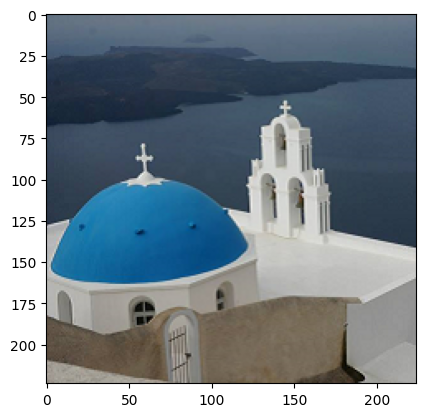

In [ ]:
model.eval()
output = model(img_tensor)

pred = imagenet_labels[int(torch.argmax(output))]
print(f"Image label prediction: {pred}")
plt.imshow(img)

## On ViT's contribution
The major novelty of the ViT was breaking an image into patches and learning patch embeddings.

At inference, ViT
1) Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).

2) Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.

3) Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same

4) MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.

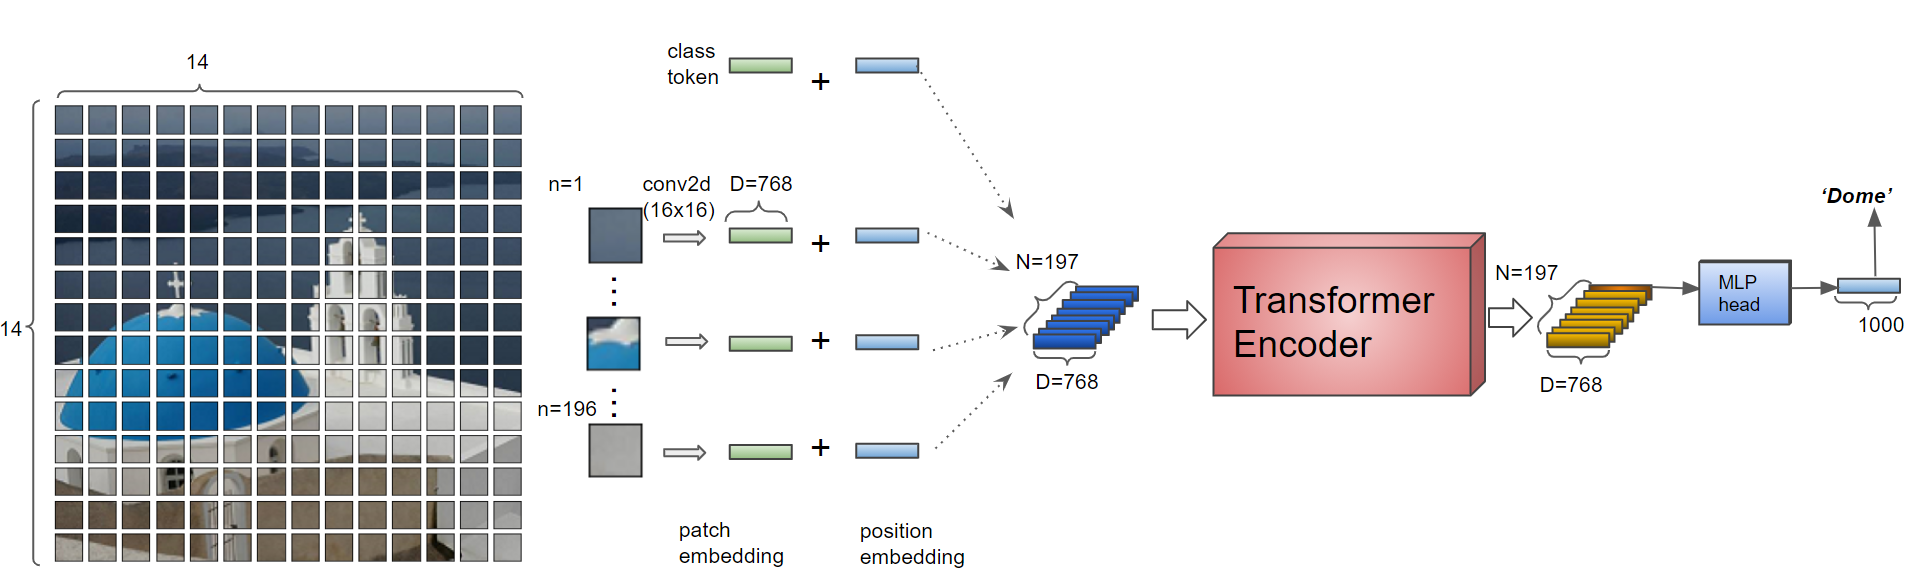

## Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to $D=N*C$ embedding vectors by learnable 2D convolution for $C$ channels.

Lets make a 2D convolution with PyTorch to apply to `img_tensor`. Create the variable
- `filter`: a `Conv2d` with
  - in_channels = img channels
  - out_channels = image_patch_size * image_patch_size * img channels
  - kernel_size = (16,16)
  - stride=(16,16)

and send `img_tensor` through it to make sure our resulting tensor would be the correct size for the ViT embedding layer. Note it will not be the same shape as `patches`.

In [ ]:
# Be sure to send filter to device
filter = nn.Conv2d(3, 16 * 16 * 3, kernel_size=(16, 16), stride=(16, 16)).to(device)
patches_filter = filter(img_tensor)


patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings shape: ", patches.shape)
print("Filtered patch shape: ", patches_filter.shape)

assert patches_filter.size(dim=2) == 14 and patches_filter.size(dim=3) == 14

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings shape:  torch.Size([1, 196, 768])
Filtered patch shape:  torch.Size([1, 768, 14, 14])


Let's visualize the image proken into patches

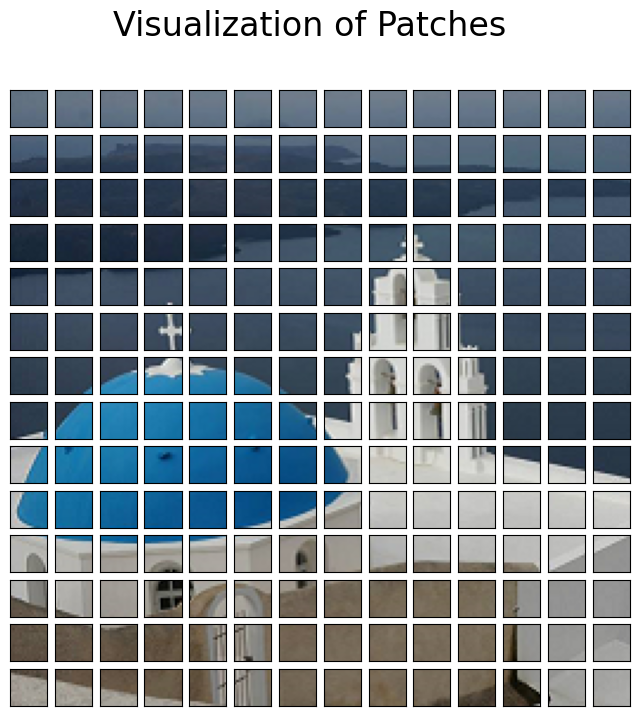

In [ ]:
# This is NOT a part of the pipeline.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
# fig.add_axes()
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

## Visualize positional embeddings
Now that we have broken our image into patches, let us try and visualize the positional embeddings obtained from ViT's embedding layer through comparing position similarities

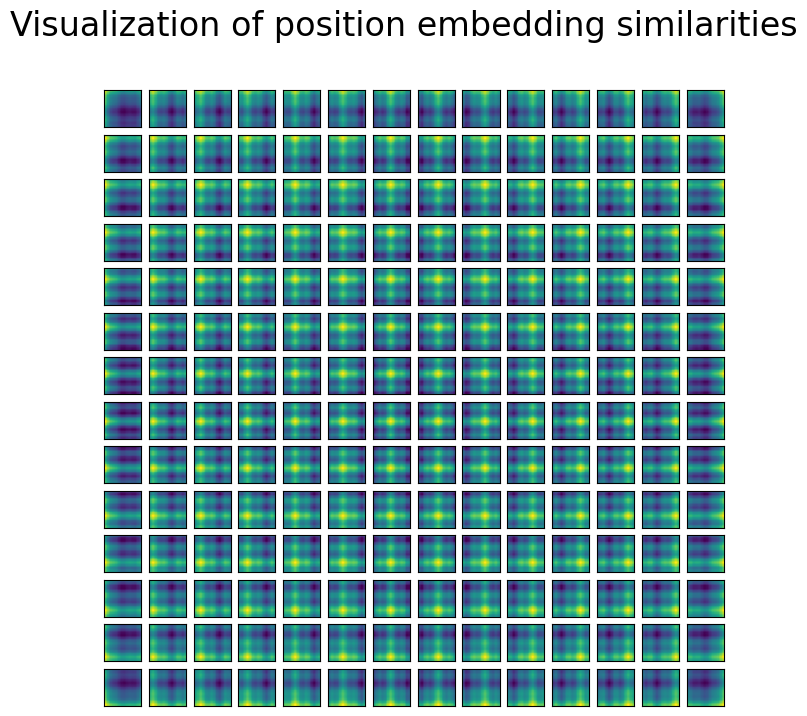

In [ ]:
pos_embed = model.pos_embed

cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

Below we create a npy file you will include when submitting the homework. We recommend running this last once you've completed the notebook. Make sure to download `submit.npy` to inlucde with our `ipynb` file.

In [ ]:
test_tensor = torch.rand(inputs.shape).to(device)
network.eval()

patch_count = np.array([num_patches])
patch_dimension = np.array([patch_dim])

# Reshapping to a 2D array
patch_filter = np.squeeze(patches_filter.detach().cpu().numpy(), 0)
patch_filter = rearrange(patch_filter, 'h w i -> h (i w)')

output = network(test_tensor).detach().cpu().numpy()
loss = np.array([running_loss])

values = [patch_count, patch_dimension, output, loss, patch_filter]
value_names = ['patch_count', 'patch_dimension', 'output', 'loss', 'patch_filter']
val_pairs = list(zip(value_names, values))

with open('submit.csv', 'w') as f:
  for pair in val_pairs:
    f.write(pair[0] + '\n')
    np.savetxt(f, pair[1], delimiter=',', fmt='%.4f')
    f.write('\n')

This cites and extends
- Paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929
- Paper: Ashish Vaswani et al., "Attentino is All You Need", https://arxiv.org/abs/1706.03762
- Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  ViT demo
- Phil Wang's pytorch-vit
